In [1]:
import numpy as np
import pandas as pd
from itertools import groupby
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train = pd.read_parquet("/kaggle/input/zzzzzz/Zzzs_train.parquet")

In [3]:
def make_features(df):
    # parse the timestamp and create an "hour" feature
    df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
    df["hour"] = df["timestamp"].dt.hour
    
    periods = 20
    df["anglez"] = abs(df["anglez"])
    df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").astype('float16')
    df["anglez_rolling_mean"] = df["anglez"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_mean"] = df["enmo"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_max"] = df["anglez"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_max"] = df["enmo"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_rolling_std"] = df["anglez"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_rolling_std"] = df["enmo"].rolling(periods,center=True).std().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_mean"] = df["anglez_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_mean"] = df["enmo_diff"].rolling(periods,center=True).mean().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["anglez_diff_rolling_max"] = df["anglez_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    df["enmo_diff_rolling_max"] = df["enmo_diff"].rolling(periods,center=True).max().fillna(method="bfill").fillna(method="ffill").astype('float16')
    
    return df

features = ["hour",
            "anglez",
            "anglez_rolling_mean",
            "anglez_rolling_max",
            "anglez_rolling_std",
            "anglez_diff",
            "anglez_diff_rolling_mean",
            "anglez_diff_rolling_max",
            "enmo",
            "enmo_rolling_mean",
            "enmo_rolling_max",
            "enmo_rolling_std",
            "enmo_diff",
            "enmo_diff_rolling_mean",
            "enmo_diff_rolling_max",
           ]

In [4]:
train   = make_features(train)

X = train[features]
y = train["awake"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

/tmp/ipykernel_27/3676500284.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
/tmp/ipykernel_27/3676500284.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["anglez_diff"] = df.groupby('series_id')['anglez'].diff(periods=periods).fillna(method="bfill").astype('float16')
/tmp/ipykernel_27/3676500284.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["enmo_diff"] = df.groupby('series_id')['enmo'].diff(periods=periods).fillna(method="bfill").asty

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score

# Check for GPU availability
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Your existing model definition
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early Stopping and Model Checkpoint
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model
model.fit(
    X_train, y_train,
    validation_split=0.3,
    batch_size=64,
    callbacks=[es, mc],
    epochs=3
)


Default GPU Device: /device:GPU:0
Epoch 1/3
115199/115199 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9315
Epoch 1: val_loss improved from inf to 0.16038, saving model to best_model.h5
115199/115199 [==============================] - 466s 4ms/step - loss: 0.1879 - accuracy: 0.9315 - val_loss: 0.1604 - val_accuracy: 0.9447
Epoch 2/3
    44/115199 [..............................] - ETA: 6:59 - loss: 0.1679 - accuracy: 0.9414

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


115194/115199 [============================>.] - ETA: 0s - loss: 0.1669 - accuracy: 0.9392
Epoch 2: val_loss improved from 0.16038 to 0.15743, saving model to best_model.h5
115199/115199 [==============================] - 462s 4ms/step - loss: 0.1669 - accuracy: 0.9392 - val_loss: 0.1574 - val_accuracy: 0.9468
Epoch 3/3
115194/115199 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9413
Epoch 3: val_loss improved from 0.15743 to 0.14690, saving model to best_model.h5
115199/115199 [==============================] - 463s 4ms/step - loss: 0.1621 - accuracy: 0.9413 - val_loss: 0.1469 - val_accuracy: 0.9491


Epoch 1/3
115187/115199 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9424
Epoch 1: val_loss did not improve from 0.14690
115199/115199 [==============================] - 468s 4ms/step - loss: 0.1597 - accuracy: 0.9424 - val_loss: 0.1505 - val_accuracy: 0.9497
Epoch 2/3
115191/115199 [============================>.] - ETA: 0s - loss: 0.1582 - accuracy: 0.9431
Epoch 2: val_loss did not improve from 0.14690
115199/115199 [==============================] - 467s 4ms/step - loss: 0.1582 - accuracy: 0.9431 - val_loss: 0.1501 - val_accuracy: 0.9465
Epoch 3/3
115189/115199 [============================>.] - ETA: 0s - loss: 0.1573 - accuracy: 0.9436
Epoch 3: val_loss did not improve from 0.14690
115199/115199 [==============================] - 466s 4ms/step - loss: 0.1573 - accuracy: 0.9436 - val_loss: 0.1501 - val_accuracy: 0.9485


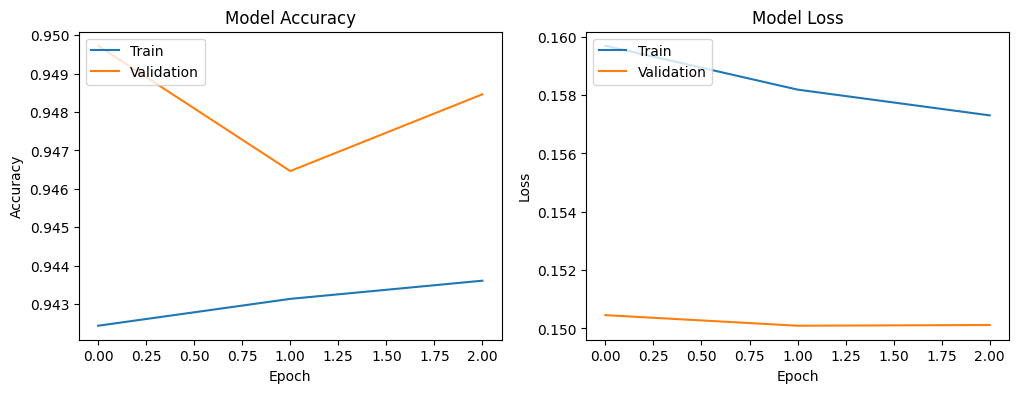

In [6]:
import matplotlib.pyplot as plt

history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    batch_size=64,
    callbacks=[es, mc],
    epochs=3
)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
